## Bibliotecas

In [1]:
import torch
import os
import random
import numpy                as np
import pandas               as pd
import torch.nn.functional  as F
import matplotlib.pyplot    as plt
import seaborn              as sns
import plotly.graph_objects as go
import plotly.express       as px

import tensorflow as tf
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score
from torchvision import transforms

from PIL                         import Image
from torch                       import nn, optim
from torch.nn.modules            import padding
from torch.nn.modules.activation import ReLU

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

from torchvision                 import datasets
from plotly.subplots             import make_subplots
from google.colab                import drive

print("Versão:",torch.__version__)

Versão: 2.0.1+cu118


## Leitura de dados

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp /content/gdrive/MyDrive/kaggle_api/kaggle.json ~/.kaggle/kaggle.json

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d shiekhburhan/face-mask-dataset

100% 2.33G/2.33G [00:39<00:00, 78.2MB/s]
100% 2.33G/2.33G [00:39<00:00, 64.1MB/s]


In [7]:
! unzip face-mask-dataset.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: FMD_DATASET/with_mask/simple/simple771.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple772.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple773.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple774.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple775.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple776.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple777.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple778.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple779.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple78.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple780.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple781.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple782.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple783.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple784.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple785.jpg  
  inflating: F

## Tratamento de dados

In [8]:
categorias = ['incorrect','with','without']

In [9]:
# Define as transformações que serão aplicadas nas imagens
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define o caminho para a pasta contendo as imagens
data_path = '/content/FMD_DATASET/'

# Cria o dataset usando a classe ImageFolder
dataset = ImageFolder(root=data_path, transform=transform)

# Verifica a quantidade de rótulos
num_labels = len(dataset.classes)

# Imprime a quantidade de rótulos
print("Quantidade de rótulos:", num_labels)

# Define a proporção de divisão (por exemplo, 80% para treinamento e 20% para teste)
train_ratio = 0.8
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

# Divide o dataset em treinamento e teste
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Cria um DataLoader para carregar os dados de treinamento em lotes
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Cria um DataLoader para carregar os dados de teste em lotes
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Quantidade de rótulos: 3


In [10]:
print(len(train_dataloader)*32, len(test_dataloader)*32)

11648 2912


## Model

In [12]:
# Definição do bloco de convolução
def convolutional_block(in_channels, out_channels, kernel_size, stride=1, padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.1)
    )

# Definição do bloco residual
def residual_block(in_channels, out_channels):
    return nn.Sequential(
        convolutional_block(in_channels, out_channels, 1),
        convolutional_block(out_channels, in_channels, 3, padding=1),
        convolutional_block(in_channels, out_channels, 1)
    )

# Definição do modelo YOLO
class Yolo(nn.Module):
    def __init__(self, num_classes):
        super(Yolo, self).__init__()

        self.num_classes = num_classes
        self.num_anchors = 3

        # Backbone
        self.conv1 = convolutional_block(3, 16, 3, padding=1)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv2 = convolutional_block(16, 32, 3, padding=1)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.conv3 = residual_block(32, 64)
        self.maxpool3 = nn.MaxPool2d(2, 2)
        self.conv4 = residual_block(64, 128)
        self.maxpool4 = nn.MaxPool2d(2, 2)
        self.conv5 = residual_block(128, 256)

        # Detection Head
        self.conv6 = convolutional_block(256, 512, 3, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, self.num_anchors * (5 + self.num_classes))

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.conv4(x)
        x = self.maxpool4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Criação de uma instância do modelo
model = Yolo(num_classes=3)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
criterion = nn.CrossEntropyLoss()

In [14]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device,"\n")

model.to(device)

cuda 



Yolo(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Batch

## Fit

In [15]:
def train(model, dataLoader, criterion, optimizer):
    model.train()
    cumloss = 0.0
    for imagens, rotulos in dataLoader:
        imagens = imagens.to(device)
        rotulos = rotulos.to(device)

        pred = model(imagens)
        loss = criterion(pred, rotulos)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cumloss += loss.item()

    return cumloss / len(dataLoader)


def validacao(model, dataLoader, lossfunc):
    model.eval()
    cumloss = 0.0

    with torch.no_grad():
        for imgs, labels in dataLoader:

            imgs, labels = imgs.to(device), labels.to(device)

            pred = model(imgs)

            loss = lossfunc(pred, labels)

            cumloss += loss.item()

    return cumloss / len(dataLoader)

epochs = 20
losses_treino = []
losses_teste = []

for i in range(epochs):
  loss_treino = train(model, train_dataloader, criterion, optimizer)
  losses_treino.append(loss_treino)
  if (i%2==0):
    print(f"Época: {i}; Loss Treino: {loss_treino}")

  loss_val = validacao(model, test_dataloader, criterion)
  losses_teste.append(loss_val)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Época: 0; Loss Treino: 0.31633490114728663
Época: 2; Loss Treino: 0.13566290400154724
Época: 4; Loss Treino: 0.11168630659109452
Época: 6; Loss Treino: 0.1007738374371931
Época: 8; Loss Treino: 0.08603135374781502
Época: 10; Loss Treino: 0.07218283662607045
Época: 12; Loss Treino: 0.07047367524221325
Época: 14; Loss Treino: 0.06259049479046883
Época: 16; Loss Treino: 0.055700303753438166
Época: 18; Loss Treino: 0.046831129655062226


## Metricas

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

def plot_loss(losses):
    fig = plt.figure(figsize=(13,5))
    ax = fig.gca()
    for loss_name, loss_values in losses.items():
        ax.plot(loss_values, label=loss_name)
    ax.legend(fontsize="16")
    ax.set_xlabel("Epoch", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs epochs", fontsize="16")
    plt.show()

def make_confusion_matrix(model, loader, num_classes):
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            _, predictions = torch.max(output, 1)
            for label, prediction in zip(labels.view(-1), predictions.view(-1)):
                confusion_matrix[label, prediction] += 1
    return confusion_matrix

def evaluate_metrics(model, loader, classes, verbose=True):
    pred_correct = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    confusion_matrix = make_confusion_matrix(model, loader, len(classes))

    if verbose:
        total_correct = 0.0
        total_predicted = 0.0

        for i, classname in enumerate(classes):
            correct_count = confusion_matrix[i, i]
            class_pred = np.sum(confusion_matrix[i])

            total_correct += correct_count
            total_predicted += class_pred

            accuracy = 100 * correct_count / class_pred
            precision = precision_score(confusion_matrix[:, i], confusion_matrix[i, :])
            recall = recall_score(confusion_matrix[:, i], confusion_matrix[i, :])
            f1 = f1_score(confusion_matrix[:, i], confusion_matrix[i, :])

            print("Class {}: Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1-score: {:.2f}".format(
                classname, accuracy, precision, recall, f1))

        print("Overall Accuracy: {:.2f}".format(100 * total_correct / total_predicted))

    return confusion_matrix

def test(model, loader, classes):
    pred_correct = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            _, predictions = torch.max(output, 1)
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    pred_correct[classes[label]] += 1
                total_pred[classes[label]] += 1

    total_correct = 0.0
    total_predicted = 0.0
    for class_name, correct_count in pred_correct.items():
        total_correct += correct_count
        total_predicted += total_pred[class_name]
        accuracy = 100 * correct_count / total_pred[class_name]
        print("Class {}: Accuracy: {:.2f}".format(class_name, accuracy))
    print("Overall Accuracy: {:.2f}".format(100 * total_correct / total_predicted))

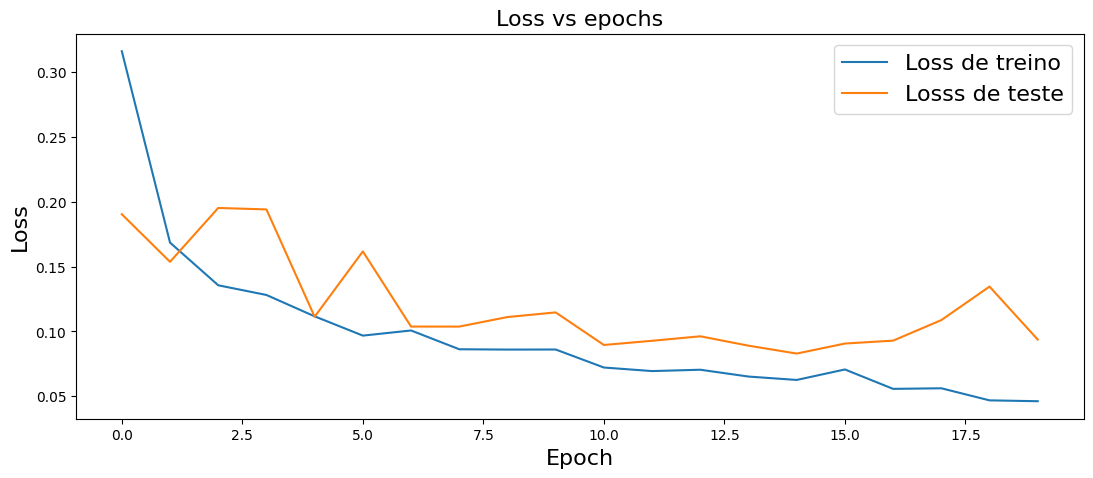

In [17]:
grafico_de_train = {'Loss de treino':losses_treino,
                  'Losss de teste':losses_teste}

plot_loss(grafico_de_train)

In [18]:
categorias = ['incorrect','with','without']

test(model, test_dataloader, categorias)

Class incorrect: Accuracy: 98.21
Class with: Accuracy: 97.31
Class without: Accuracy: 95.83
Overall Accuracy: 97.15


<Axes: >

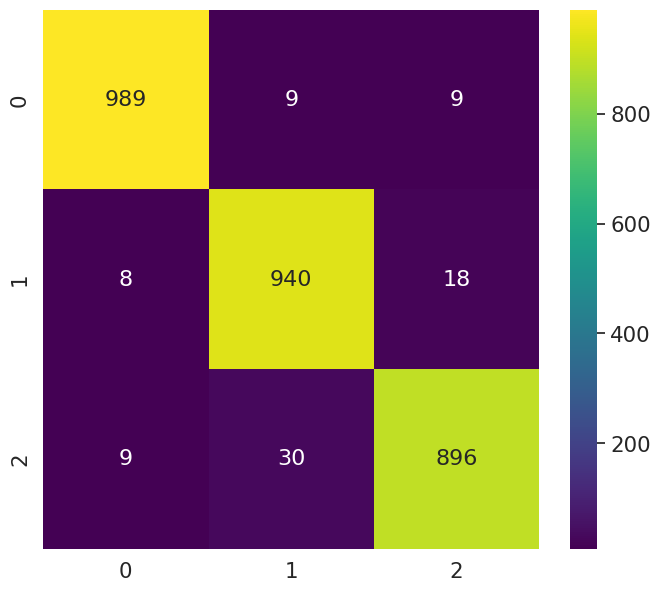

In [19]:
matriz = make_confusion_matrix(model, test_dataloader, 3)

plt.figure(figsize=(8, 7))
sns.set(font_scale=1.4)
sns.heatmap(matriz.tolist(),
           annot=True, annot_kws={"size": 16}, fmt='d', cmap='viridis')

In [20]:
# Salvando o estado do modelo CNN
torch.save(model.state_dict(), '/content/gdrive/MyDrive/mask_detection_weights.pt')

In [21]:
#model = classificador()
model.load_state_dict(torch.load('/content/gdrive/MyDrive/mask_detection_weights.pt'))
model.eval()

# Agora você pode acessar as chaves do modelo
print(f"Chaves: {model.state_dict().keys()}")

Chaves: odict_keys(['conv1.0.weight', 'conv1.0.bias', 'conv1.1.weight', 'conv1.1.bias', 'conv1.1.running_mean', 'conv1.1.running_var', 'conv1.1.num_batches_tracked', 'conv2.0.weight', 'conv2.0.bias', 'conv2.1.weight', 'conv2.1.bias', 'conv2.1.running_mean', 'conv2.1.running_var', 'conv2.1.num_batches_tracked', 'conv3.0.0.weight', 'conv3.0.0.bias', 'conv3.0.1.weight', 'conv3.0.1.bias', 'conv3.0.1.running_mean', 'conv3.0.1.running_var', 'conv3.0.1.num_batches_tracked', 'conv3.1.0.weight', 'conv3.1.0.bias', 'conv3.1.1.weight', 'conv3.1.1.bias', 'conv3.1.1.running_mean', 'conv3.1.1.running_var', 'conv3.1.1.num_batches_tracked', 'conv3.2.0.weight', 'conv3.2.0.bias', 'conv3.2.1.weight', 'conv3.2.1.bias', 'conv3.2.1.running_mean', 'conv3.2.1.running_var', 'conv3.2.1.num_batches_tracked', 'conv4.0.0.weight', 'conv4.0.0.bias', 'conv4.0.1.weight', 'conv4.0.1.bias', 'conv4.0.1.running_mean', 'conv4.0.1.running_var', 'conv4.0.1.num_batches_tracked', 'conv4.1.0.weight', 'conv4.1.0.bias', 'conv4.1.1